# Self-Driving Car Engineering
## Advanced Lane Finding
A pipeline to detect lanes in a video stream using perspective transform, histogram peaks, and a polynomial curve fit.

The goals / steps of this project are the following:

* Compute a camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

### Step 1: Camera Calibration

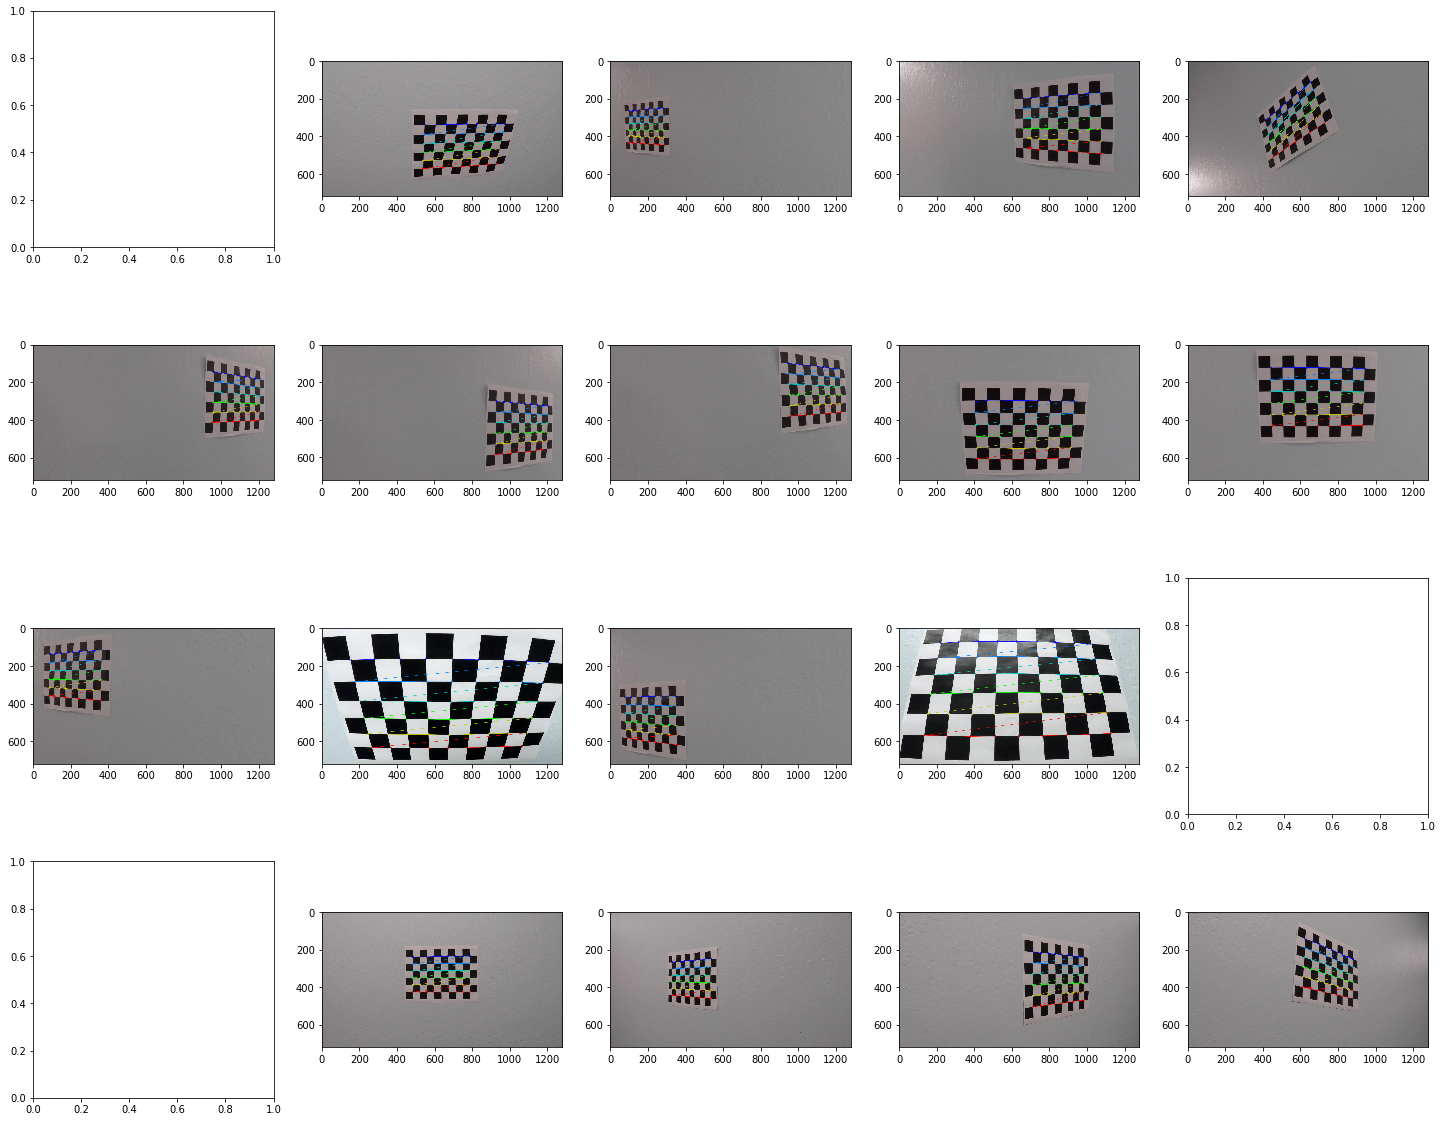

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# display the corners
f, axs = plt.subplots(4,5, figsize=(25, 20))
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].imshow(img)


#### Visualize the distortion correction on chessboard images and road image

Text(0.5,1,'Undistorted Image')

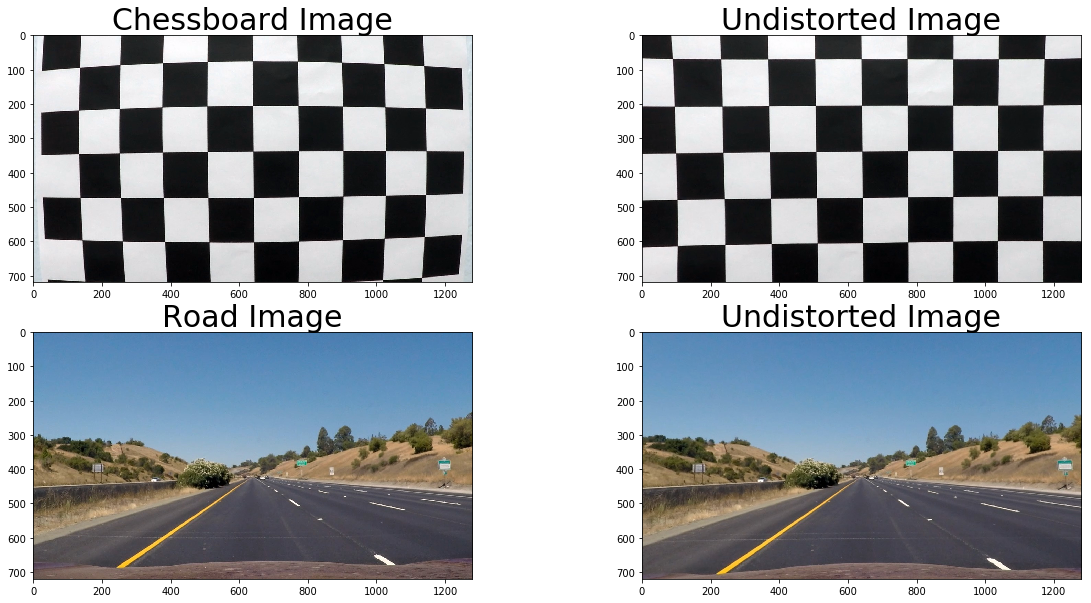

In [3]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
# dist_pickle = {}
# dist_pickle["mtx"] = mtx
# dist_pickle["dist"] = dist
# pickle.dump( dist_pickle, open( "camera_cal/dist_pickle.p", "wb" ) )

# undistort the checkerboard image and a road image
dst = cv2.undistort(img, mtx, dist, None, mtx)
road_image = cv2.imread('test_images/straight_lines1.jpg')
road_image = cv2.cvtColor(road_image, cv2.COLOR_BGR2RGB)
road_undistort = cv2.undistort(road_image, mtx, dist, None, mtx)


# Visualize undistortion
f, axs = plt.subplots(2, 2, figsize=(20,10))
axs = axs.ravel()
axs[0].imshow(img)
axs[0].set_title('Chessboard Image', fontsize=30)
axs[1].imshow(dst)
axs[1].set_title('Undistorted Image', fontsize=30)
axs[2].imshow(road_image)
axs[2].set_title('Road Image', fontsize=30)
axs[3].imshow(road_undistort)
axs[3].set_title('Undistorted Image', fontsize=30)


### Step 2: Define a perspective transform
Applying a perspective transform will allow us to determine curvature of the lines, as well as make it easier to separate the lines near the horizon, where they typically appear to converge.

In [4]:
# This function takes an image, a list of source points and destination points,
#  determines the transformation matrix and warps the image accordingly
def get_transform_and_warp(image, src_pts, dst_pts):
    img_size = image.shape[1], image.shape[0]
    
    # get the perspective transform matrices, forward and reverse
    # we will need the reverse to map the lane lines back to the original image
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    
    warped = cv2.warpPerspective(image, M, img_size)
    
    return warped, M, Minv
    

In [5]:
# Same thing but assumes you already have the transformation matrix
def birds_eye_warp(image, M):
    img_size = image.shape[1], image.shape[0]
    
    warped = cv2.warpPerspective(image, M, img_size)
    
    return warped

#### Try the perspective transform on an example image

900


Text(0.5,1,'Perspective Transform Result')

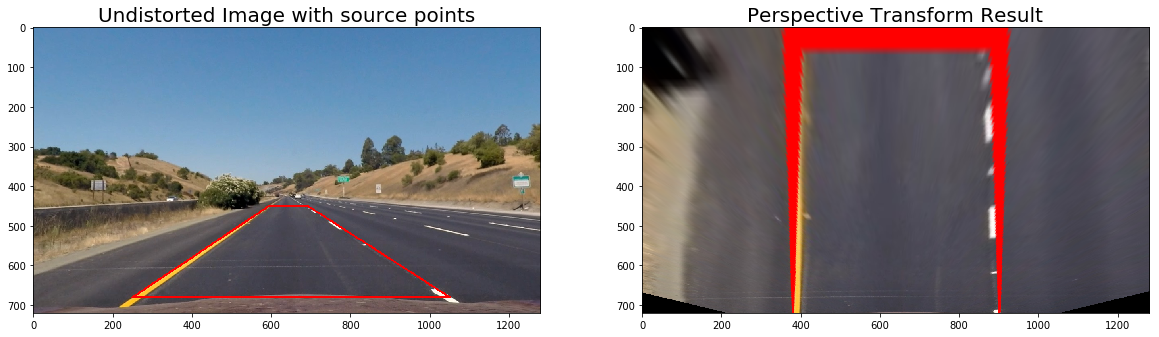

In [6]:
h,w  = (road_image.shape[0], road_image.shape[1])

# Define the transformation corners
src_pts = np.float32([(594,450),
                      (692,450), 
                      (250,680), 
                      (1050,680)])

loc = 380
dst_pts = np.float32([(loc,0),
                      (w-loc,0),
                      (loc,h),
                      (w-loc,h)])

print(w-loc)

# draw the perspective transform mbox on the original, undistorted image
cv2.line(road_undistort, tuple(src_pts[0]), tuple(src_pts[1]),(255,0,0), 3)
cv2.line(road_undistort, tuple(src_pts[1]), tuple(src_pts[3]),(255,0,0), 3)
cv2.line(road_undistort, tuple(src_pts[2]), tuple(src_pts[3]),(255,0,0), 3)
cv2.line(road_undistort, tuple(src_pts[2]), tuple(src_pts[0]),(255,0,0), 3)

# Perform the perspective transformation to create a birds eye view
warped, M, Minv = get_transform_and_warp(road_undistort, src_pts, dst_pts)



f, axs = plt.subplots(1,2, figsize=(20,10))
axs.ravel()
axs[0].imshow(road_undistort)
axs[0].set_title('Undistorted Image with source points', fontsize=20)
axs[1].imshow(warped)
axs[1].set_title('Perspective Transform Result', fontsize=20)


### Step 3: Gradient and Color Thresholding
The raw image needs to be thresholded in order to determine where the lane lines are. Typically, the lines are a different color value than the surrounding pavement, but only in certain color spaces. The key is finding color spaces with high constrasts between the pavement and the lines, and a low contrast between the lines in the sun, and the lines in a shadow. The HLS colorspace works well for our requirements.

In [7]:
# This function thresholds an image using the a sobel x-direction threshold on the HLS L-channel,
# and a magnitude threshold on the HLS S-channel
def threshold_pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold S-channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the results
    result_binary = s_binary | sxbinary
    return result_binary

#### Try the thresholding pipeline on an example image

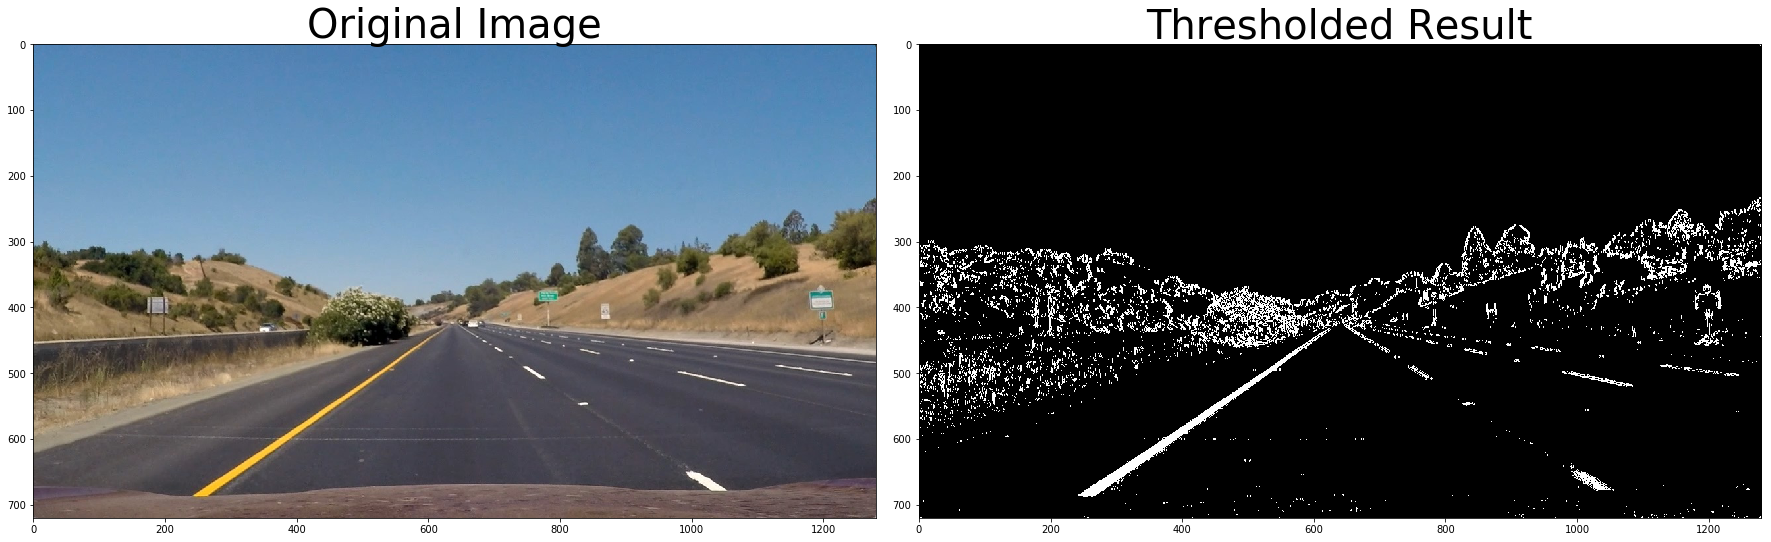

In [8]:
thresholded = threshold_pipeline(road_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### See how the thresholded image looks after a perspective transform

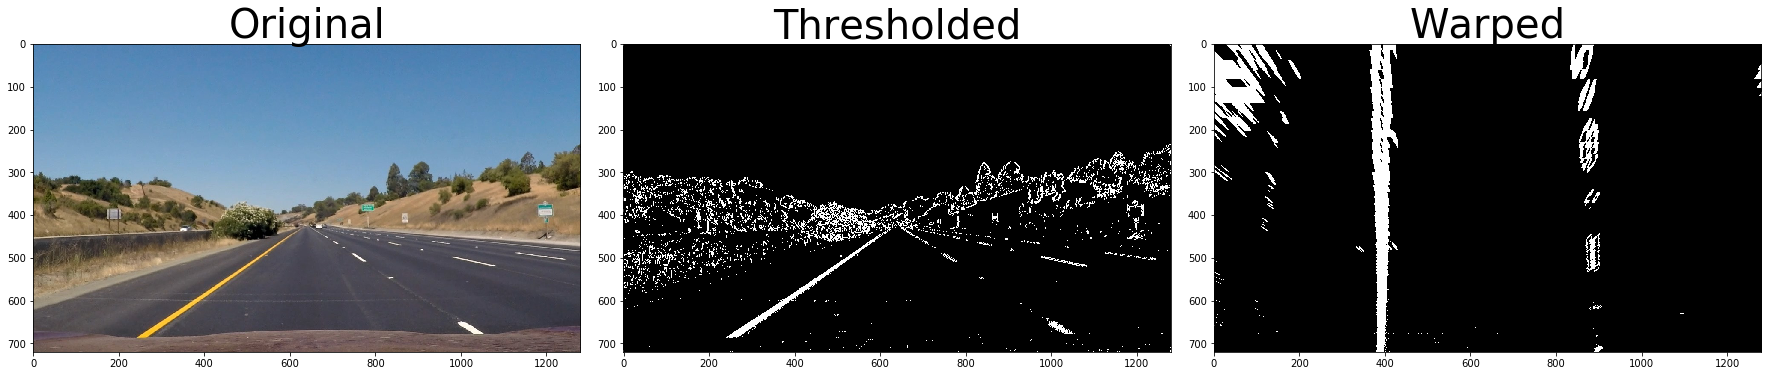

In [9]:
warped = birds_eye_warp(thresholded, M)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(road_image)
ax1.set_title('Original', fontsize=40)

ax2.imshow(thresholded, cmap='gray')
ax2.set_title('Thresholded', fontsize=40)

ax3.imshow(warped, cmap='gray')
ax3.set_title('Warped', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


### Step 4: Fit a polynomial to the lane lines
We've done a pretty good job at making the lines stand out from the pavement. Now we want to apply some methods that will allow the computer to determine whre the lines are actually located. To do that, we will take a histogram of the image, and hopefully, there will be two peaks in the histogram where the lane lines are. First we want to define a way to search for the lanes from scratch, when we have no previous detections, or we lost a previous detection.

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    nwindows = 9    # Choose the number of sliding windows
    margin = 100    # Set the width of the windows +/- margin
    minpix = 50     # Set minimum number of pixels found to recenter window


    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_new_polynomial(binary_warped):
    ym_per_pix = 40.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/520.0 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit new polynomials to x,y in world space
    left_fit_world = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_world = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
#     cv2.polylines(img, pts, isClosed, color[, thickness[, lineType[, shift]]]) → None
#     print(len(left_fitx))
#     print(right_fitx)
#     print(ploty)

 
    # shitty data wrangling you need to do every time you use numpy and openCV
    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))
    
    cv2.fillPoly(out_img, np.int_([points]), (0,255, 0))
    cv2.polylines(out_img, np.int32([points_left]), isClosed=False,color=(255,0,0), thickness=15)
    cv2.polylines(out_img, np.int32([points_right]), isClosed=False,color=(0,0,255), thickness=15)
    
    # calculate center distance
    left_pos = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
    right_pos = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]
    center = (left_pos + right_pos) / 2
    center_dist = (binary_warped.shape[1]/2 - center) * (3.7/520);

#     out_img[lefty, leftx] = [255, 0, 0]
#     out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fit_world, right_fit_world, center_dist

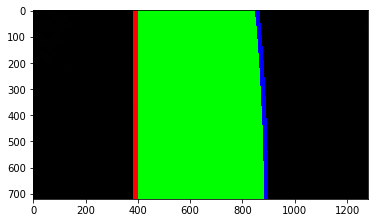

In [11]:
out_img, left_fit, right_fit, left_fit_world, right_fit_world, center_dist = fit_new_polynomial(warped)
plt.imshow(out_img)

Once we have found the lane, we can search the next frame within a close proximity of the detected lane, since the lane does not move much between frames.

In [12]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

def search_around_poly(binary_warped, left_prev_fit, right_prev_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 50
    ym_per_pix = 40.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/520.0 # meters per pixel in x dimension

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_prev_fit[0]*(nonzeroy**2) + left_prev_fit[1]*nonzeroy + 
                    left_prev_fit[2] - margin)) & (nonzerox < (left_prev_fit[0]*(nonzeroy**2) + 
                    left_prev_fit[1]*nonzeroy + left_prev_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_prev_fit[0]*(nonzeroy**2) + right_prev_fit[1]*nonzeroy + 
                    right_prev_fit[2] - margin)) & (nonzerox < (right_prev_fit[0]*(nonzeroy**2) + 
                    right_prev_fit[1]*nonzeroy + right_prev_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty, left_fit, right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Fit new polynomials to x,y in world space
    left_fit_world = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_world = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # shitty data wrangling you need to do every time you use numpy and openCV
    points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points = np.hstack((points_left, points_right))
    
    cv2.fillPoly(out_img, np.int_([points]), (0,255, 0))
    cv2.polylines(out_img, np.int32([points_left]), isClosed=False,color=(255,0,0), thickness=15)
    cv2.polylines(out_img, np.int32([points_right]), isClosed=False,color=(0,0,255), thickness=15)
    
    # calculate center distance
    left_pos = left_fit[0]*binary_warped.shape[0]**2 + left_fit[1]*binary_warped.shape[0] + left_fit[2]
    right_pos = right_fit[0]*binary_warped.shape[0]**2 + right_fit[1]*binary_warped.shape[0] + right_fit[2]
    center = (left_pos + right_pos) / 2
    center_dist = (binary_warped.shape[1]/2 - center) * (3.7/520);
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
    return out_img, left_fit, right_fit, left_fit_world, right_fit_world, center_dist

### Step 5: Warp the lane image back to original perspective and overlay onto the original

In [13]:
def inverse_warp_and_overlay(image, lane_image, Minv):
    warped = birds_eye_warp(lane_image, Minv)
    result = cv2.addWeighted(image, 1.0, warped, 0.3, 0.0)
    return result
 
    

### Step 6: Measure the curvature of the lane

In [14]:
def measure_curvature_real(image, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 40.0/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/520.0 # meters per pixel in x dimension
    
#     # Start by generating our fake example data
#     # Make sure to feed in your real data instead in your project!
#     ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = image.shape[0]
#     y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    cv2.putText(image, 'Radius: {:5.1f} m'.format((left_curverad + right_curverad) / 2.0), (40,40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2, cv2.LINE_AA)
    
    return image

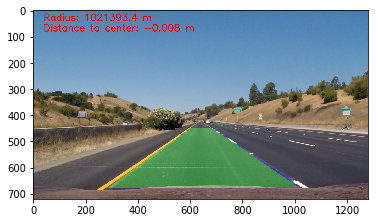

In [15]:
result = inverse_warp_and_overlay(road_image, out_img, Minv)
result = measure_curvature_real(result, left_fit_world, right_fit_world)
cv2.putText(result, 'Distance to center: {:1.3f} m'.format(center_dist), (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2, cv2.LINE_AA)


plt.imshow(result)

Display the mapped lane and the radius of curvature value

Build the pipeline

In [16]:
def pipeline(image):
    try:
        pipeline.counter += 1
    except AttributeError:
        pipeline.counter = 0
        prev_left_fit = ()
        prev_right_fit = ()
        
    # Undistort
    result = cv2.undistort(image, mtx, dist, None, mtx)
        
    
    # threshold and perspective transform
    result = threshold_pipeline(image)
    result = birds_eye_warp(result, M)
    
    # find the lane for the first time or search around previous detection
    if pipeline.counter == 0:
        result, left_fit, right_fit, left_fit_world, right_fit_world, center_dist = fit_new_polynomial(result)
    else:
        result, left_fit, right_fit, left_fit_world, right_fit_world, center_dist = search_around_poly(result, pipeline.prev_left_fit, pipeline.prev_right_fit)
        
    result = inverse_warp_and_overlay(image, result, Minv)
    result = measure_curvature_real(result, left_fit_world, right_fit_world)
    if center_dist < 0:
        center_dist = abs(center_dist)
        cv2.putText(result, '{:3.1f} m left of center'.format(center_dist), (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2, cv2.LINE_AA)
    else:
        cv2.putText(result, '{:3.1f} m right of center'.format(center_dist), (40,80), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255,0,0), 2, cv2.LINE_AA)

    pipeline.prev_left_fit = left_fit.copy()
    pipeline.prev_right_fit = right_fit.copy()
    
    pipeline.counter += 1
    return result

Functionality to grab and edit frames from a video

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'test_videos_output/result.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip

clip1 = VideoFileClip("project_video.mp4")#.subclip(10,15)
clip = clip1.fl_image(pipeline) # NOTE: this function expects color images!!
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video test_videos_output/result.mp4
[MoviePy] Writing video test_videos_output/result.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:06<00:00,  9.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/result.mp4 

Wall time: 2min 7s
